# Classifying Alljoined1 with EEGNet
### Structure of the notebook:

__Setup__
- 0. Import libraries
- 1. Mount drive
- 2. Install and load dataset
- 3. Build COCO supercategory mapping
  - 3.1 Encode the labels
- 4. Dataset class and split

__Building and training__
- 5. Build EEGNet
- 6. Hyperpar. tuning
- 7. Train final model

__Testing__
- 8. Evaluations and metrics
- 9. Analysis of most important channels


## 0. Import libraries

In [ ]:
!pip install --quiet datasets pycocotools mne
from google.colab import drive
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    average_precision_score,
    hamming_loss,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import mne

## 1. Mount drive

In [1]:
# Mount Google Drive
drive.mount('/content/drive')

# Directories for caches and artifacts
DRIVE_ROOT = '/content/drive/MyDrive'
HF_CACHE = os.path.join(DRIVE_ROOT, 'hf_cache')
COCO_DIR  = os.path.join(DRIVE_ROOT, 'coco_annotations')
CKPT_DIR  = os.path.join(DRIVE_ROOT, 'eegnet_checkpoints')
for d in [HF_CACHE, COCO_DIR, CKPT_DIR]: os.makedirs(d, exist_ok=True)

# Set environment for Hugging Face cache
os.environ['HF_HOME'] = HF_CACHE
os.environ['XDG_CACHE_HOME'] = HF_CACHE

Mounted at /content/drive


## 2. Install & load dataset

In [2]:
dataset = load_dataset('Alljoined/05_125')
# We use all available subjects
subjects = sorted(set(dataset['train']['subject_id']))
print(f"Loaded data for subjects: {subjects}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 4.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-c

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded data for subjects: [1, 2, 3, 4, 5, 6, 7, 8]


## 3. Build COCO supercategory mapping

In [3]:
# Annotations already on Drive
ann_dir = os.path.join(COCO_DIR, 'annotations')
if not os.path.isdir(ann_dir):
    # download and unzip if missing
    !wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip \
        -O '{os.path.join(COCO_DIR, 'annotations_trainval2017.zip')}'
    !unzip -q '{os.path.join(COCO_DIR, 'annotations_trainval2017.zip')}' -d '{COCO_DIR}'
# Load category→supercategory
with open(f"{ann_dir}/instances_train2017.json") as f: train_ann = json.load(f)
cat2sup = {c['id']: c['supercategory'] for c in train_ann['categories']}
# Build image→sup set
img2sup = {}
for split in ['train','val']:
    with open(f"{ann_dir}/instances_{split}2017.json") as f: data = json.load(f)
    for img in data['images']: img2sup[img['id']] = set()
    for ann in data['annotations']: img2sup[ann['image_id']].add(cat2sup[ann['category_id']])
print(f"Built mapping for {len(img2sup)} COCO images.")

Built mapping for 123287 COCO images.


## 3.1 Encode the labels

In [4]:
all_sup = sorted({s for sups in img2sup.values() for s in sups})
sup2idx = {sup:i for i,sup in enumerate(all_sup)}
dim_labels = len(all_sup)
print("Superclasses:", all_sup)

Superclasses: ['accessory', 'animal', 'appliance', 'electronic', 'food', 'furniture', 'indoor', 'kitchen', 'outdoor', 'person', 'sports', 'vehicle']


## 4. Dataset class & split

In [5]:
class EEGDataset(Dataset):
    def __init__(self, hf_ds, subject_list):
        # Filter by subjects
        self.data = hf_ds.filter(lambda x: x['subject_id'] in subject_list)
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        row = self.data[idx]
        eeg = np.array(row['EEG'],dtype=np.float32)
        eeg = (eeg - eeg.mean(axis=1,keepdims=True)) / (eeg.std(axis=1,keepdims=True)+1e-6)
        eeg = eeg[np.newaxis,...]  # (1,64,T)
        label = np.zeros(dim_labels, np.float32)
        for sup in img2sup.get(row['coco_id'],[]): label[sup2idx[sup]] = 1.0
        return torch.tensor(eeg), torch.tensor(label)

# Split subjects: train=first 6, val=1, test=1
train_sub, temp_sub = subjects[:6], subjects[6:]
val_sub, test_sub = temp_sub[0:1], temp_sub[1:2]
print(f"Train subs: {train_sub}, Val subs: {val_sub}, Test subs: {test_sub}")

# Create dataloaders
batch_size=32
train_ds = EEGDataset(dataset['train'], train_sub)
val_ds   = EEGDataset(dataset['train'], val_sub)
test_ds  = EEGDataset(dataset['test'],  test_sub)
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size)
test_loader  = DataLoader(test_ds,  batch_size)
print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)} trials")


Train subs: [1, 2, 3, 4, 5, 6], Val subs: [7], Test subs: [8]


Filter:   0%|          | 0/34354 [00:00<?, ? examples/s]

Filter:   0%|          | 0/34354 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8716 [00:00<?, ? examples/s]

Train: 28282, Val: 3061, Test: 763 trials


## 5. EEGNet model

In [6]:
def make_eegnet(chans=64, samples=334, dropout=0.25, n_classes=dim_labels):
    net = nn.Sequential(
        nn.Conv2d(1,16,(1,64),padding=(0,32),bias=False), nn.BatchNorm2d(16), nn.ELU(),
        nn.Conv2d(16,32,(chans,1),groups=16,bias=False), nn.BatchNorm2d(32), nn.ELU(),
        nn.AvgPool2d((1,4)), nn.Dropout(dropout),
        nn.Conv2d(32,32,(1,16),padding=(0,8),bias=False), nn.BatchNorm2d(32), nn.ELU(),
        nn.AvgPool2d((1,8)), nn.Dropout(dropout),
        nn.Flatten(), nn.Linear(32 * (samples//(4*8)), n_classes)
    )
    return net

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 6. Hyperparameter tuning (with grid search)

lr=0.001, drop=0.2 → mAP=0.209
lr=0.001, drop=0.5 → mAP=0.221
lr=0.0001, drop=0.2 → mAP=0.190
lr=0.0001, drop=0.5 → mAP=0.181


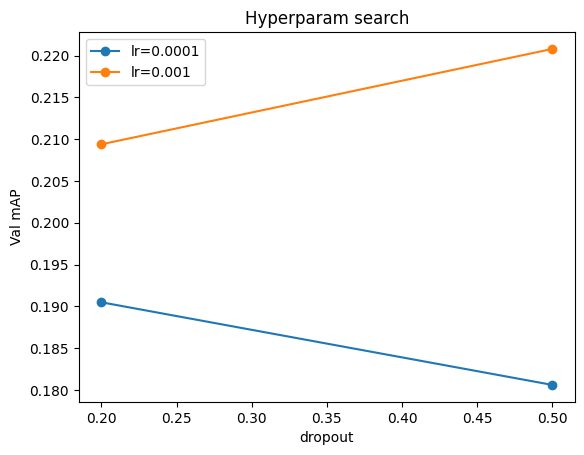

Best params (lr,drop): (0.001, 0.5)


In [7]:
grid = {'lr':[1e-3,1e-4], 'dropout':[0.2,0.5]}
results = []
for lr in grid['lr']:
    for dr in grid['dropout']:
        model = make_eegnet(dropout=dr).to(device)
        opt = optim.Adam(model.parameters(), lr=lr)
        # one epoch training
        model.train()
        for x,y in train_loader:
            opt.zero_grad(); out=model(x.to(device)); loss=F.binary_cross_entropy_with_logits(out,y.to(device)); loss.backward(); opt.step()
        # evaluate on val
        model.eval();
        ys, ps = [], []
        with torch.no_grad():
            for x,y in val_loader:
                o = torch.sigmoid(model(x.to(device))).cpu().numpy(); ys.append(y.numpy()); ps.append(o)
        ys, ps = np.vstack(ys), np.vstack(ps)
        mAP = average_precision_score(ys,ps,average='macro')
        results.append((lr,dr,mAP))
        print(f"lr={lr}, drop={dr} → mAP={mAP:.3f}")
# Plot
lrs = sorted(set(r[0] for r in results))
for lr in lrs:
    drs = [r[1] for r in results if r[0]==lr]
    maps = [r[2] for r in results if r[0]==lr]
    plt.plot(drs,maps,'-o',label=f"lr={lr}")
plt.xlabel('dropout'); plt.ylabel('Val mAP'); plt.title('Hyperparam search'); plt.legend(); plt.show()
# Pick best
best = max(results, key=lambda x: x[2]); print("Best params (lr,drop):", best[:2])

## 7. Train final model

In [8]:
best_lr, best_dr, _ = best
model = make_eegnet(dropout=best_dr).to(device)
opt = torch.optim.Adam(model.parameters(), lr=best_lr)
# combine train+val
combined_loader = DataLoader(torch.utils.data.ConcatDataset([train_ds,val_ds]), batch_size, shuffle=True)

n_epochs=5
for epoch in range(n_epochs:=n_epochs if 'n_epochs' in globals() else 5):
    model.train();
    for x,y in combined_loader: opt.zero_grad(); loss=F.binary_cross_entropy_with_logits(model(x.to(device)),y.to(device)); loss.backward(); opt.step()
print("Final model trained on train+val.")
# Save checkpoint
torch.save(model.state_dict(), os.path.join(CKPT_DIR,'eegnet_multisubj.pth'))

Final model trained on train+val.


## 8. Test evaluation & metrics

Test AP per class:
  accessory: 0.188
  animal: 0.448
  appliance: 0.222
  electronic: 0.084
  food: 0.124
  furniture: 0.223
  indoor: 0.216
  kitchen: 0.214
  outdoor: 0.108
  person: 0.574
  sports: 0.286
  vehicle: 0.178
mAP: 0.2387771873837613
Hamming Loss: 0.16229794670161643
Classification Report (single-label argmax):
              precision    recall  f1-score   support

   accessory       0.00      0.00      0.00        59
      animal       0.38      0.59      0.46       204
   appliance       0.00      0.00      0.00        82
  electronic       0.00      0.00      0.00        32
        food       0.00      0.00      0.00        56
   furniture       0.12      0.05      0.07        40
      indoor       0.00      0.00      0.00        35
     kitchen       0.00      0.00      0.00         4
     outdoor       0.00      0.00      0.00        51
      person       0.27      0.71      0.39       158
      sports       0.00      0.00      0.00         0
     vehicle       0.00

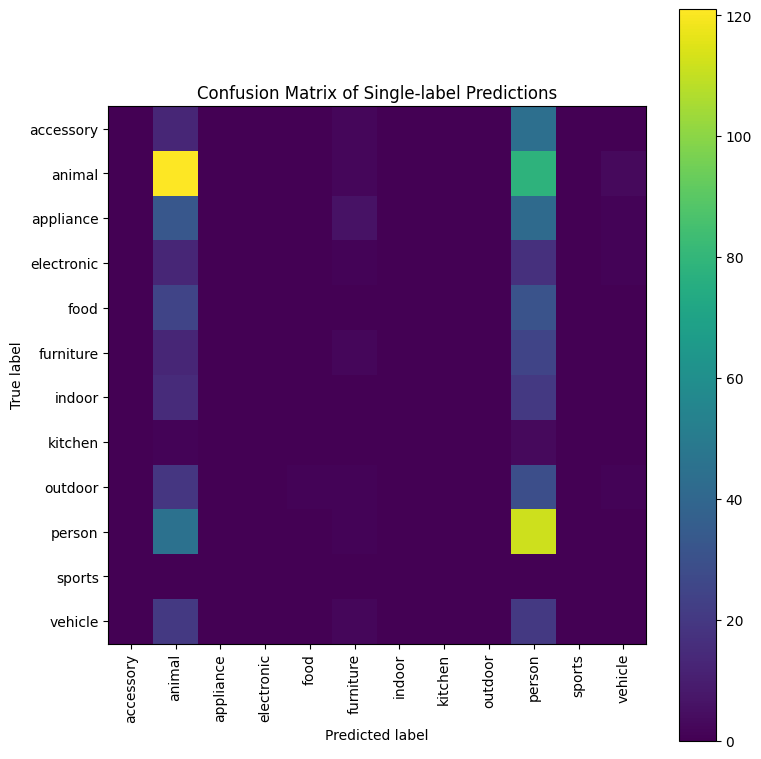

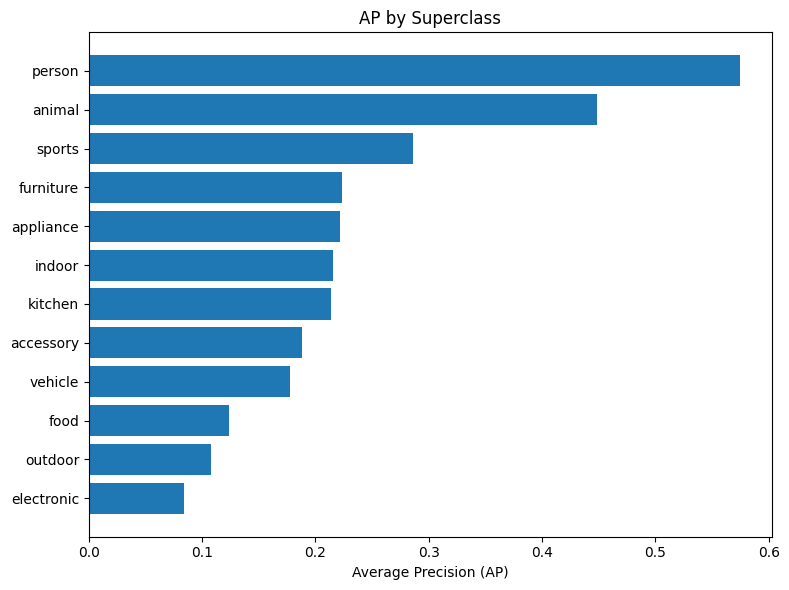

In [20]:
# Ensure model is in eval mode
model.eval()

# Collect true labels and predicted probabilities for multi-label metrics
ys, ps = [], []
with torch.no_grad():
    for x, y in test_loader:
        o = torch.sigmoid(model(x.to(device))).cpu().numpy()
        ys.append(y.numpy()); ps.append(o)
ys, ps = np.vstack(ys), np.vstack(ps)

# Multi-label evaluation
aps = average_precision_score(ys, ps, average=None)
print("Test AP per class:")
for i, sup in enumerate(all_sup):
    print(f"  {sup}: {aps[i]:.3f}")
print("mAP:", aps.mean())
print("Hamming Loss:", hamming_loss(ys, (ps >= 0.5).astype(int)))

# Single-label confusion & classification report
preds = np.argmax(ps, axis=1)
trues = np.argmax(ys, axis=1)
labels = list(range(dim_labels))
print("Classification Report (single-label argmax):")
print(classification_report(trues, preds, labels=labels, target_names=all_sup, zero_division=0))

cm = confusion_matrix(trues, preds, labels=labels)
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix of Single-label Predictions')
plt.xlabel('Predicted label'); plt.ylabel('True label')
plt.xticks(labels, all_sup, rotation=90)
plt.yticks(labels, all_sup)
plt.colorbar()
plt.tight_layout(); plt.show()

# Bar chart of AP per class
aps = np.array(aps)  # from your Cell 8
inds = np.argsort(aps)
plt.figure(figsize=(8,6))
plt.barh(np.array(all_sup)[inds], aps[inds])
plt.xlabel("Average Precision (AP)")
plt.title("AP by Superclass")
plt.tight_layout()
plt.show()


## 9. Highlight Top Channels on a 2D 10‑20 Layout

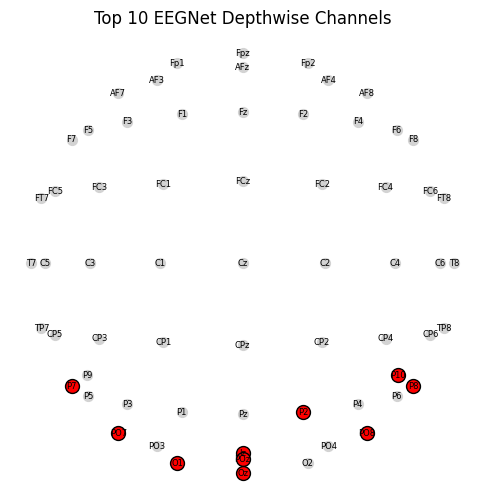

Top 10 channels by importance:
  P8: 0.1478
  Oz: 0.1174
  P7: 0.1156
  P10: 0.1149
  PO7: 0.1056
  POz: 0.0998
  O1: 0.0971
  P2: 0.0965
  PO8: 0.0952
  Iz: 0.0934


In [19]:
# 1) Compute importances from the depthwise Conv layer in the Sequential model
# depthwise conv is the 4th module: model[3]
w = model[3].weight.detach().cpu().numpy().squeeze()  # shape (32, 1, 64, 1) -> squeeze() -> (32,64)
imp = np.mean(np.abs(w), axis=0)  # (64,) per-channel importance

# 2) Load 10-20 biosemi64 montage and extract 2D positions
montage = mne.channels.make_standard_montage('biosemi64')
pos3d = montage.get_positions()['ch_pos']  # dict: ch_name -> (x,y,z)
# drop z for 2D layout
pos2d = {ch: np.array(coord)[:2] for ch, coord in pos3d.items()}
topo_names = montage.ch_names

# 3) Normalize coordinates to unit circle
coords = np.array([pos2d for pos2d in pos2d.values()])  # unused
xs = np.array([pos2d[ch][0] for ch in topo_names])
ys = np.array([pos2d[ch][1] for ch in topo_names])
scale = np.max(np.sqrt(xs**2 + ys**2))
xs /= scale; ys /= scale

# 4) Identify top 10 channels by importance
top10_idx = np.argsort(imp)[-10:]

# 5) Plot layout with highlighted channels
plt.figure(figsize=(6,6))
plt.scatter(xs, ys, c='lightgray', s=50)
for i, ch in enumerate(topo_names):
    plt.text(xs[i], ys[i], ch, fontsize=6, ha='center', va='center')
for i in top10_idx:
    plt.scatter(xs[i], ys[i], c='red', s=100, edgecolors='k')
plt.title('Top 10 EEGNet Depthwise Channels')
plt.axis('off')
plt.show()

# 6) Print top 10 list
print('Top 10 channels by importance:')
for idx in top10_idx[::-1]:
    print(f"  {topo_names[idx]}: {imp[idx]:.4f}")